In [1]:
import nltk
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import gensim

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [2]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


In [3]:
sns.set_context('talk')

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data


# Data

In [6]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
class_corpus = get_corpus_df(CORPUS_PATH)

In [7]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 90 to 164
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB


# Preprocessing

In [8]:
STOP_WORDS = set(nltk.corpus.stopwords.words('english'))

In [9]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()

def remove_tags(text):
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

def remove_stop_words(tokenized_text):
    custom_stop_words = ['movies', 'movie', 'film', 'films', 'scene']
    STOP_WORDS.update(custom_stop_words)
    return [w for w in tokenized_text if not w in STOP_WORDS]

In [10]:
def normalize(input_text):
    '''
    Normalization involves the following steps:
    1. Remove punctuation
    2. Lower case all words
    3. Remove tags (i.e., HTML tags)
    4. Remove all special characters and digits
    '''
    text = remove_punctuation(input_text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)

    return text

In [11]:
def tokenize(text):
    '''
    Tokenization involves the following steps:
    1. Break text down to tokens (i.e., words separated by white spaces)
    2. Remove stop words from the tokens generated in step 1
    '''
    tokens = nltk.word_tokenize(text)
    tokenized_text = remove_stop_words(tokens)

    return tokenized_text

In [12]:
def lemmatize(tokenized_text, lemmatizer=WordNetLemmatizer()):
    '''
    Lemmatization is applied to each word in the list of normalized tokens
    (stop words are removed)
    '''
    return [lemmatizer.lemmatize(word) for word in tokenized_text]

In [13]:
def join_tokens(lemmatized_tokens):
    return ' '.join(lemmatized_tokens)

In [14]:
def get_multi_classification_performance_metrics(X_test, y_test, model, model_name):
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)[::-1]
  plt.figure(figsize=(8,6), dpi=100)
  # Scale up the size of all text
  sns.set(font_scale = 1.1)

  # Plot Confusion Matrix using Seaborn heatmap()
  # Parameters:
  # first param - confusion matrix in array format
  # annot = True: show the numbers in each heatmap cell
  # fmt = 'd': show numbers as integers.
  ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")

  # set x-axis label and ticks.
  ax.set_xlabel("Predicted Genre", fontsize=14, labelpad=20)
  ax.xaxis.set_ticklabels(['Action', 'Comedy', 'Horror', 'Sci-Fi'])

  # set y-axis label and ticks
  ax.set_ylabel("Actual Genre", fontsize=14, labelpad=20)
  ax.yaxis.set_ticklabels(['Action', 'Comedy', 'Horror', 'Sci-Fi'][::-1])

  # set plot title
  ax.set_title(f"Confusion Matrix for {model_name}", fontsize=12, pad=20)

  plt.show()
  print('\n')
  print(classification_report(y_test, y_pred))
  print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
  print(f"Test F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
  print(f"Test Precision: {precision_score(y_test, y_pred, average='weighted')}")
  print(f"Test Recall: {recall_score(y_test, y_pred, average='weighted')}")


def get_binary_classification_performance_metrics(X_test, y_test, model, model_name):
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)[::-1]
  plt.figure(figsize=(8,6), dpi=100)
  # Scale up the size of all text
  sns.set(font_scale = 1.1)

  # Plot Confusion Matrix using Seaborn heatmap()
  # Parameters:
  # first param - confusion matrix in array format
  # annot = True: show the numbers in each heatmap cell
  # fmt = 'd': show numbers as integers.
  ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")

  # set x-axis label and ticks.
  ax.set_xlabel("Predicted Genre", fontsize=14, labelpad=20)
  ax.xaxis.set_ticklabels(['Negative', 'Positive'])

  # set y-axis label and ticks
  ax.set_ylabel("Actual Genre", fontsize=14, labelpad=20)
  ax.yaxis.set_ticklabels(['Negative', 'Positive'][::-1])

  # set plot title
  ax.set_title(f"Confusion Matrix for {model_name}", fontsize=14, pad=20)

  plt.show()
  print('\n')
  print(classification_report(y_test, y_pred))
  print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
  print(f"Test F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
  print(f"Test Precision: {precision_score(y_test, y_pred, average='weighted')}")
  print(f"Test Recall: {recall_score(y_test, y_pred, average='weighted')}")

In [15]:
class_corpus['normalized_review'] = class_corpus['Text'].apply(normalize)
class_corpus['tokenized_review'] = class_corpus['normalized_review'].apply(tokenize)
class_corpus['lemmatized_tokens'] = class_corpus['tokenized_review'].apply(lemmatize)
class_corpus['lemmatized_text'] = class_corpus['lemmatized_tokens'].apply(join_tokens)

In [16]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 90 to 164
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
 9   normalized_review         200 non-null    object
 10  tokenized_review          200 non-null    object
 11  lemmatized_tokens         200 non-null    object
 12  lemmatized_text           200 non-null    object
dtypes: int64(1), object(12)
memory usage: 21.9+ KB


# Feature Extraction

## TF-IDF

In [21]:
tfidf_vectorizer = TfidfVectorizer()

In [22]:
dtm_class_corpus = tfidf_vectorizer.fit_transform(class_corpus['lemmatized_text'])

In [23]:
features_tfidf_scores = pd.DataFrame(dtm_class_corpus.toarray(),
                                     columns=tfidf_vectorizer.get_feature_names_out(),
                                     index=class_corpus.index)

In [24]:
features_tfidf_scores.shape

(200, 10077)

# Sentiment Analysis

In [25]:
labels = class_corpus['Review Type (pos or neg)']

In [26]:
labels.value_counts()

Negative    100
Positive    100
Name: Review Type (pos or neg), dtype: int64

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features_tfidf_scores, labels,
                                                    test_size=0.33,
                                                    random_state=20130810)

In [28]:
y_train

Doc_ID
80     Positive
128    Positive
136    Positive
100    Positive
61     Positive
         ...   
31     Positive
130    Negative
140    Negative
169    Negative
138    Positive
Name: Review Type (pos or neg), Length: 134, dtype: object

The best paramaters should of course be estimated through a hyperparameter tuning loop.

## Support Vector Machine

In [29]:
for C_value in [0.01, 0.1, 1, 10, 100, 1000, 10000]:
    model_svm = SVC(C=C_value, random_state=10)
    model_svm.fit(X_train, y_train)
    y_pred = model_svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"C: {C_value}, Accuracy: {acc}")

C: 0.01, Accuracy: 0.5151515151515151
C: 0.1, Accuracy: 0.5151515151515151
C: 1, Accuracy: 0.5454545454545454
C: 10, Accuracy: 0.48484848484848486
C: 100, Accuracy: 0.48484848484848486
C: 1000, Accuracy: 0.48484848484848486
C: 10000, Accuracy: 0.48484848484848486


The best accuracy is when `C = 1`.


In [30]:
model_svm = SVC(C=1)
model_svm.fit(X_train, y_train)

SVC(C=1)

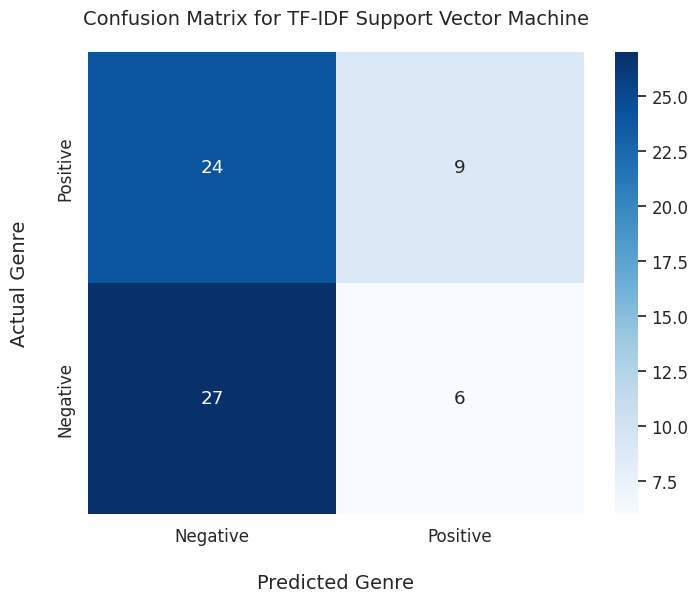



              precision    recall  f1-score   support

    Negative       0.53      0.82      0.64        33
    Positive       0.60      0.27      0.37        33

    accuracy                           0.55        66
   macro avg       0.56      0.55      0.51        66
weighted avg       0.56      0.55      0.51        66

Test Accuracy: 0.5454545454545454
Test F1 Score: 0.5089285714285713
Test Precision: 0.5647058823529412
Test Recall: 0.5454545454545454


In [31]:
get_binary_classification_performance_metrics(X_test, y_test, model_svm, 'TF-IDF Support Vector Machine')

# Decision Tree

In [32]:
for max_depth in range(1,20):
  model_dtc = DTC(max_depth=max_depth, random_state=10)
  model_dtc.fit(X_train, y_train)
  y_pred = model_dtc.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"max_depth: {max_depth}\tAccuracy: {acc}")

max_depth: 1	Accuracy: 0.5303030303030303
max_depth: 2	Accuracy: 0.4393939393939394
max_depth: 3	Accuracy: 0.3787878787878788
max_depth: 4	Accuracy: 0.4393939393939394
max_depth: 5	Accuracy: 0.4696969696969697
max_depth: 6	Accuracy: 0.4696969696969697
max_depth: 7	Accuracy: 0.5151515151515151
max_depth: 8	Accuracy: 0.5151515151515151
max_depth: 9	Accuracy: 0.4696969696969697
max_depth: 10	Accuracy: 0.5
max_depth: 11	Accuracy: 0.5151515151515151
max_depth: 12	Accuracy: 0.5303030303030303
max_depth: 13	Accuracy: 0.5303030303030303
max_depth: 14	Accuracy: 0.5303030303030303
max_depth: 15	Accuracy: 0.5303030303030303
max_depth: 16	Accuracy: 0.5303030303030303
max_depth: 17	Accuracy: 0.5303030303030303
max_depth: 18	Accuracy: 0.5303030303030303
max_depth: 19	Accuracy: 0.5303030303030303


In [35]:
model_dtc = DTC(max_depth=12, random_state=10)
model_dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, random_state=10)

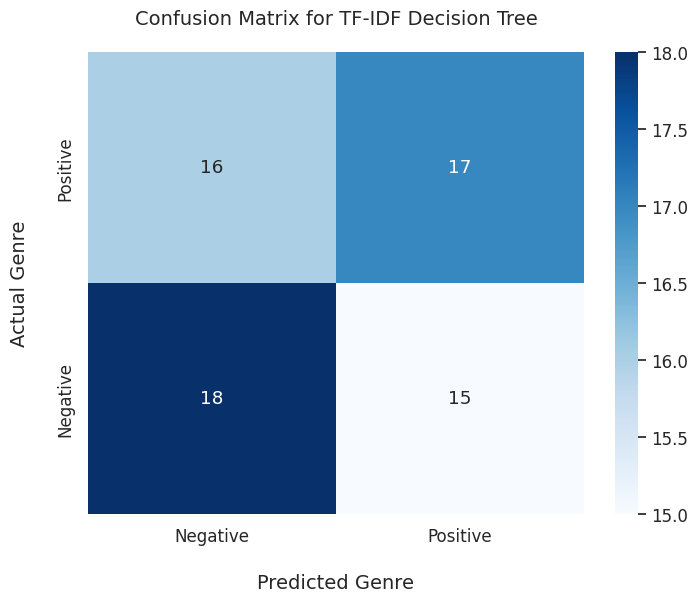



              precision    recall  f1-score   support

    Negative       0.53      0.55      0.54        33
    Positive       0.53      0.52      0.52        33

    accuracy                           0.53        66
   macro avg       0.53      0.53      0.53        66
weighted avg       0.53      0.53      0.53        66

Test Accuracy: 0.5303030303030303
Test F1 Score: 0.530195177956372
Test Precision: 0.5303308823529411
Test Recall: 0.5303030303030303


In [36]:
get_binary_classification_performance_metrics(X_test, y_test, model_dtc, 'TF-IDF Decision Tree')

## Random Forest

In [37]:
for n_estimator in range(10, 201, 10):
  model_rf = RFC(n_estimators=n_estimator, random_state=10)
  model_rf.fit(X_train, y_train)
  y_pred = model_rf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"n_estimator: {n_estimator}\tAccuracy: {acc}")

n_estimator: 10	Accuracy: 0.5303030303030303
n_estimator: 20	Accuracy: 0.5151515151515151
n_estimator: 30	Accuracy: 0.5
n_estimator: 40	Accuracy: 0.4393939393939394
n_estimator: 50	Accuracy: 0.5151515151515151
n_estimator: 60	Accuracy: 0.4696969696969697
n_estimator: 70	Accuracy: 0.5
n_estimator: 80	Accuracy: 0.5303030303030303
n_estimator: 90	Accuracy: 0.5151515151515151
n_estimator: 100	Accuracy: 0.5454545454545454
n_estimator: 110	Accuracy: 0.5151515151515151
n_estimator: 120	Accuracy: 0.5151515151515151
n_estimator: 130	Accuracy: 0.5757575757575758
n_estimator: 140	Accuracy: 0.5454545454545454
n_estimator: 150	Accuracy: 0.5151515151515151
n_estimator: 160	Accuracy: 0.48484848484848486
n_estimator: 170	Accuracy: 0.5151515151515151
n_estimator: 180	Accuracy: 0.4696969696969697
n_estimator: 190	Accuracy: 0.4696969696969697
n_estimator: 200	Accuracy: 0.45454545454545453


In [38]:
model_rf = RFC(n_estimators=130, random_state=10)
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=130, random_state=10)

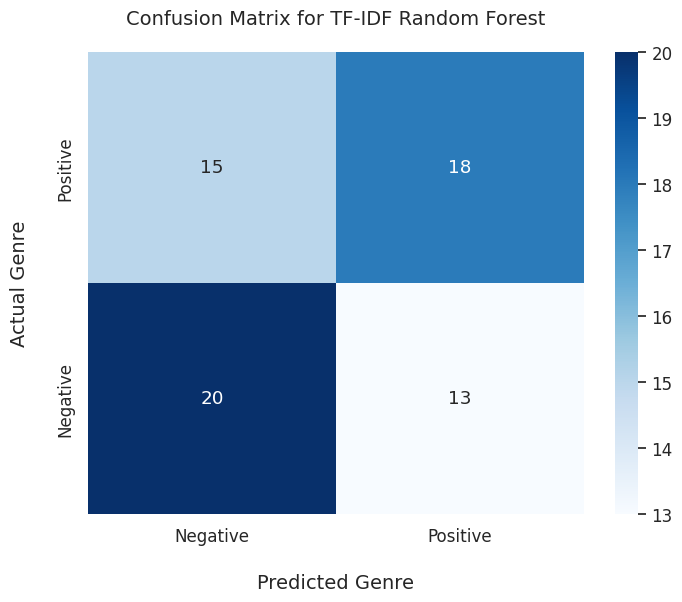



              precision    recall  f1-score   support

    Negative       0.57      0.61      0.59        33
    Positive       0.58      0.55      0.56        33

    accuracy                           0.58        66
   macro avg       0.58      0.58      0.58        66
weighted avg       0.58      0.58      0.58        66

Test Accuracy: 0.5757575757575758
Test F1 Score: 0.5753676470588235
Test Precision: 0.576036866359447
Test Recall: 0.5757575757575758


In [39]:
get_binary_classification_performance_metrics(X_test, y_test, model_rf, 'TF-IDF Random Forest')

# Multi-class Classification

In [40]:
labels = class_corpus['Genre of Movie']

In [41]:
labels.value_counts()

Action    50
Comedy    50
Horror    50
Sci-Fi    50
Name: Genre of Movie, dtype: int64

In [42]:
X_train, X_test, y_train, y_test = train_test_split(features_tfidf_scores, labels,
                                                    test_size=0.33,
                                                    stratify=labels,
                                                    random_state=20130810)

Hyperparameter tuning

In [50]:
for C_value in [0.01, 0.1, 1, 10, 100, 1000, 10000]:
    model_svm = SVC(C=C_value, random_state=10)
    model_svm.fit(X_train, y_train)
    y_pred = model_svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"C: {C_value}, Accuracy: {acc}")

C: 0.01, Accuracy: 0.48484848484848486
C: 0.1, Accuracy: 0.48484848484848486
C: 1, Accuracy: 1.0
C: 10, Accuracy: 1.0
C: 100, Accuracy: 1.0
C: 1000, Accuracy: 1.0
C: 10000, Accuracy: 1.0


In [51]:
model_svm = SVC(C=1, random_state=10)
model_svm.fit(X_train, y_train)

SVC(C=1, random_state=10)

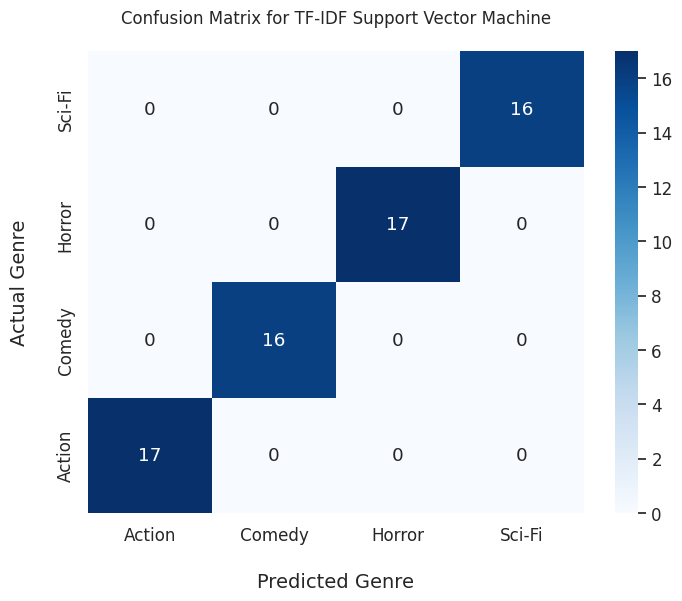



              precision    recall  f1-score   support

      Action       1.00      1.00      1.00        17
      Comedy       1.00      1.00      1.00        16
      Horror       1.00      1.00      1.00        17
      Sci-Fi       1.00      1.00      1.00        16

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Test Accuracy: 1.0
Test F1 Score: 1.0
Test Precision: 1.0
Test Recall: 1.0


In [52]:
get_multi_classification_performance_metrics(X_test, y_test, model_svm, 'TF-IDF Support Vector Machine')

## Decision Tree Classifier

In [53]:
for max_depth in range(1,20):
  model_dtc = DTC(max_depth=max_depth, random_state=10)
  model_dtc.fit(X_train, y_train)
  y_pred = model_dtc.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"max_depth: {max_depth}\tAccuracy: {acc}")


max_depth: 1	Accuracy: 0.3939393939393939
max_depth: 2	Accuracy: 0.42424242424242425
max_depth: 3	Accuracy: 0.5303030303030303
max_depth: 4	Accuracy: 0.5151515151515151
max_depth: 5	Accuracy: 0.5454545454545454
max_depth: 6	Accuracy: 0.5151515151515151
max_depth: 7	Accuracy: 0.5454545454545454
max_depth: 8	Accuracy: 0.6060606060606061
max_depth: 9	Accuracy: 0.6060606060606061
max_depth: 10	Accuracy: 0.5909090909090909
max_depth: 11	Accuracy: 0.5909090909090909
max_depth: 12	Accuracy: 0.5909090909090909
max_depth: 13	Accuracy: 0.5909090909090909
max_depth: 14	Accuracy: 0.5909090909090909
max_depth: 15	Accuracy: 0.5909090909090909
max_depth: 16	Accuracy: 0.5909090909090909
max_depth: 17	Accuracy: 0.5909090909090909
max_depth: 18	Accuracy: 0.5909090909090909
max_depth: 19	Accuracy: 0.5909090909090909


In [54]:
model_dtc = DTC(max_depth=8, random_state=10)
model_dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, random_state=10)

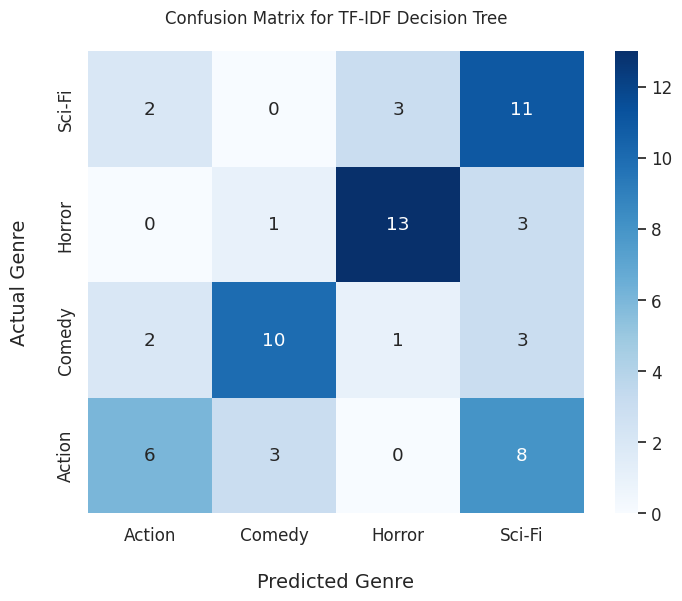



              precision    recall  f1-score   support

      Action       0.60      0.35      0.44        17
      Comedy       0.71      0.62      0.67        16
      Horror       0.76      0.76      0.76        17
      Sci-Fi       0.44      0.69      0.54        16

    accuracy                           0.61        66
   macro avg       0.63      0.61      0.60        66
weighted avg       0.63      0.61      0.60        66

Test Accuracy: 0.6060606060606061
Test F1 Score: 0.6031452738769811
Test Precision: 0.6313419913419913
Test Recall: 0.6060606060606061


In [55]:
get_multi_classification_performance_metrics(X_test, y_test, model_dtc, 'TF-IDF Decision Tree')

## Random Forest

In [56]:
for n_estimator in range(10, 201, 10):
  model_rf = RFC(n_estimators=n_estimator, random_state=10)
  model_rf.fit(X_train, y_train)
  y_pred = model_rf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"n_estimator: {n_estimator}\tAccuracy: {acc}")


n_estimator: 10	Accuracy: 0.6212121212121212
n_estimator: 20	Accuracy: 0.7272727272727273
n_estimator: 30	Accuracy: 0.8636363636363636
n_estimator: 40	Accuracy: 0.8787878787878788
n_estimator: 50	Accuracy: 0.9090909090909091
n_estimator: 60	Accuracy: 0.8939393939393939
n_estimator: 70	Accuracy: 0.9090909090909091
n_estimator: 80	Accuracy: 0.9090909090909091
n_estimator: 90	Accuracy: 0.8787878787878788
n_estimator: 100	Accuracy: 0.8939393939393939
n_estimator: 110	Accuracy: 0.9393939393939394
n_estimator: 120	Accuracy: 0.9090909090909091
n_estimator: 130	Accuracy: 0.9242424242424242
n_estimator: 140	Accuracy: 0.8939393939393939
n_estimator: 150	Accuracy: 0.9090909090909091
n_estimator: 160	Accuracy: 0.9090909090909091
n_estimator: 170	Accuracy: 0.9090909090909091
n_estimator: 180	Accuracy: 0.9242424242424242
n_estimator: 190	Accuracy: 0.9242424242424242
n_estimator: 200	Accuracy: 0.9090909090909091


In [57]:
model_rf = RFC(n_estimators=110, random_state=10)
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=110, random_state=10)

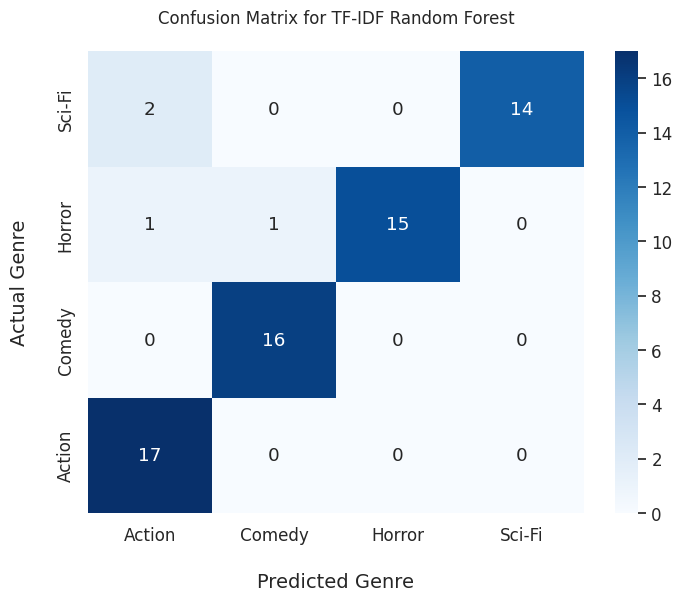



              precision    recall  f1-score   support

      Action       0.85      1.00      0.92        17
      Comedy       0.94      1.00      0.97        16
      Horror       1.00      0.88      0.94        17
      Sci-Fi       1.00      0.88      0.93        16

    accuracy                           0.94        66
   macro avg       0.95      0.94      0.94        66
weighted avg       0.95      0.94      0.94        66

Test Accuracy: 0.9393939393939394
Test F1 Score: 0.9395091889410071
Test Precision: 0.9471033868092692
Test Recall: 0.9393939393939394


In [58]:
get_multi_classification_performance_metrics(X_test, y_test, model_rf, 'TF-IDF Random Forest')

# Conclusion

When text is an input to a supervised learning task (e.g., sentiment analysis or multi-class prediction) detailed examination of the classification metrics helps select the appropriate feature engineering process.